In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
from fastai.tabular.all import *
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.cluster import hierarchy as hc
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data_v2.csv', low_memory=False)
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'id', 'Description', 'Functions', 'img_folder'], inplace=True)
df.dropna(inplace=True)
df = df[df['Year of production'] > 1900]
df = df[df['Case diameter'] > 10]
df.reset_index(inplace=True, drop=True)
df.head()

,Bracelet material,Brand,Case diameter,Case material,Condition,Dial,Gender,Location,Model,Movement,...,GMT,Tachymeter,Moon phase,Annual calendar,Perpetual calendar,Tourbillon,Flyback,Alarm,Country,is_valid
0,Steel,Bulgari,41.0,Steel,New,Black,Men's watch/Unisex,"United States of America, California, San Mateo",Octo,Automatic,...,0,0,0,0,0,0,0,0,United States of America,0
1,Steel,Tissot,39.0,Steel,New,Mother of pearl,Men's watch/Unisex,"Japan, Tokyo",PR 100,Quartz,...,0,0,0,0,0,0,0,0,Japan,1
2,Leather,Mido,41.0,Steel,New,Silver,Men's watch/Unisex,"Japan, Tokyo",Belluna,Automatic,...,0,0,0,0,0,0,0,0,Japan,0
3,Steel,Mido,42.0,Steel,New,Black,Men's watch/Unisex,"Japan, Tokyo",Multifort GMT,Automatic,...,0,0,0,0,0,0,0,0,Japan,0
4,Leather,Seiko,42.0,Steel,Unworn,Black,Men's watch/Unisex,"Japan, Tokyo",Kinetic,Quartz,...,0,0,0,0,0,0,0,0,Japan,0


In [4]:
len(df)

45639

In [5]:
def order_category(cat, order):
    df[cat] = df[cat].astype('category')
    df[cat] = df[cat].cat.set_categories(order, ordered=True)

In [6]:
bracelet = 'Platinum','White gold','Rose gold','Yellow gold','Gold/Steel','Silver', 'Titanium', 'Ceramic', 'Steel', 'Aluminium', 'Leather', 'Textile', 'Rubber'
order_category('Bracelet material', bracelet)

case = 'Platinum', 'White gold', 'Rose gold', 'Yellow gold', 'Gold/Steel', 'Silver', 'Titanium', 'Ceramic', 'Steel', 'Bronze', 'Carbon','Plastic',  'Aluminum', 'Other'
order_category('Case material', case)

condition = 'New', 'Unworn', 'Very good', 'Good', 'Fair', 'Poor'
order_category('Condition', condition)

movement = 'Automatic', 'Manual winding', 'Quartz'
order_category('Movement', movement)

delivery = 'Original box, original papers', 'Original papers, no original box', 'Original box, no original papers', 'No original box, no original papers', 
order_category('Scope of delivery', delivery)

In [7]:
cat_columns = ['Brand', 'Dial', 'Gender', 'Location',
       'private_seller', 'Crystal', 'Date', 'Weekday', 'Month', 'Chronograph', 'GMT',
       'Tachymeter', 'Moon phase', 'Annual calendar', 'Perpetual calendar',
       'Tourbillon', 'Flyback', 'Alarm', 'Country', 'Model', 'Reference number', 'Year']


for c in cat_columns:
    df[c] = df[c].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45639 entries, 0 to 45638
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Bracelet material   45639 non-null  category
 1   Brand               45639 non-null  category
 2   Case diameter       45639 non-null  float64 
 3   Case material       45639 non-null  category
 4   Condition           45639 non-null  category
 5   Dial                45639 non-null  category
 6   Gender              45639 non-null  category
 7   Location            45639 non-null  category
 8   Model               45639 non-null  category
 9   Movement            45639 non-null  category
 10  Reference number    45639 non-null  category
 11  Scope of delivery   45639 non-null  category
 12  Year of production  45639 non-null  float64 
 13  price               45639 non-null  float64 
 14  private_seller      45639 non-null  category
 15  Crystal             45639 non-null  

As shown in the histograms, watch price is heavily skewed to the left with most watches pricing in below $10k. <br>
For this reason I log-transform the dependent variable to get a distribution which is closer to normal.

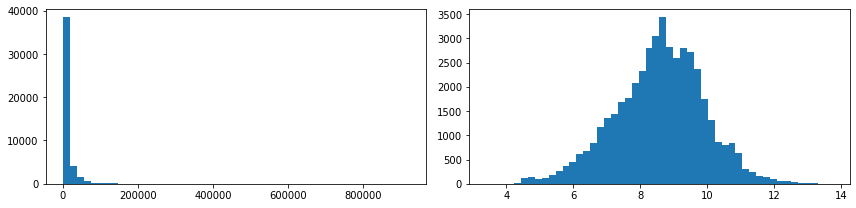

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].hist(df['price'], bins=50)
axes[1].hist(np.log(df['price']), bins=50)
fig.tight_layout()

In [10]:
df['price'] = np.log(df['price'])

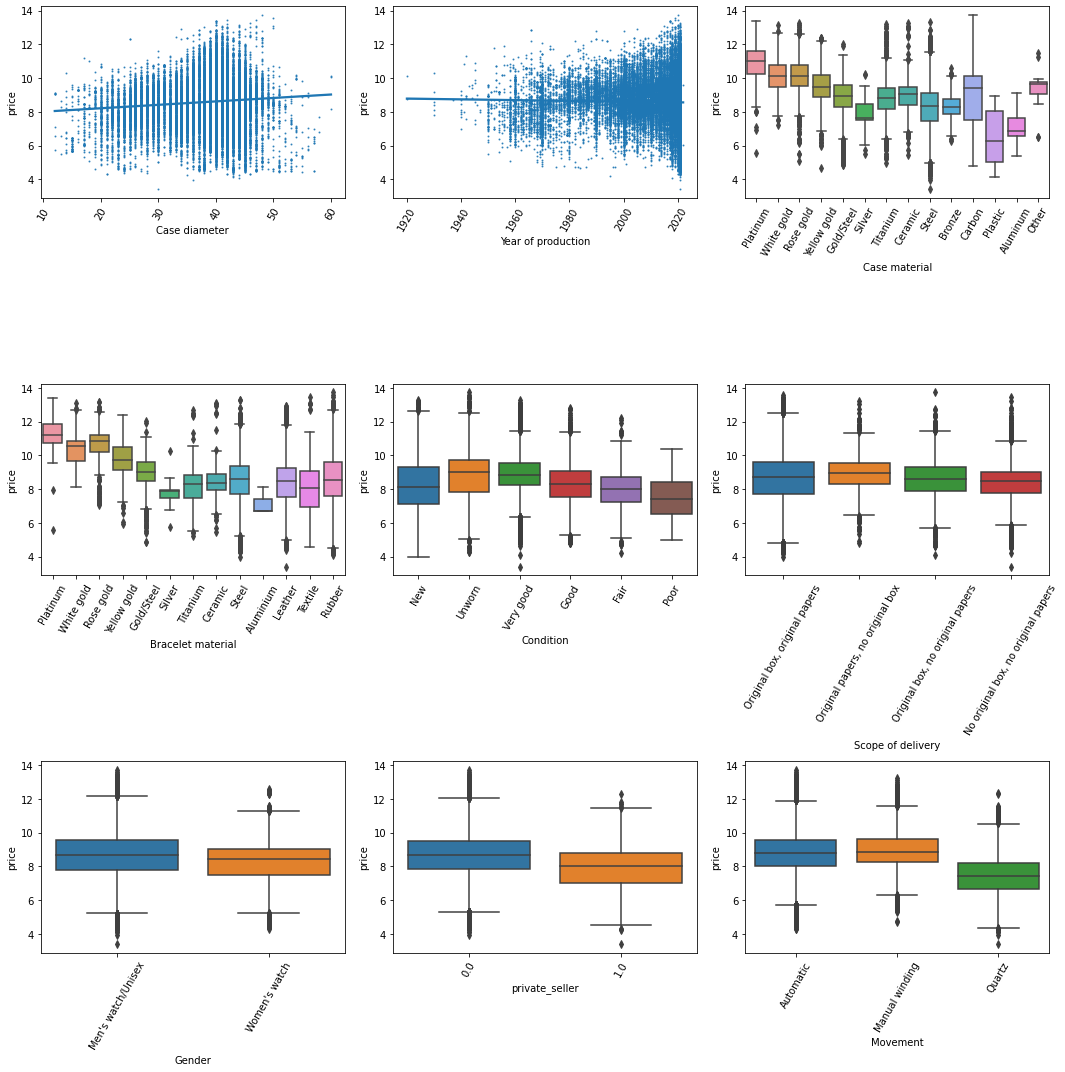

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
sns.regplot(x=df['Case diameter'], y=df['price'], ax=axes[0,0], scatter_kws={'s':1})
sns.regplot(x=df['Year of production'], y=df['price'], ax=axes[0,1], scatter_kws={'s':1})
sns.boxplot(x=df['Case material'], y=df['price'], ax=axes[0,2])
sns.boxplot(x=df['Bracelet material'], y=df['price'], ax=axes[1,0])
sns.boxplot(x=df['Condition'], y=df['price'], ax=axes[1,1])
sns.boxplot(x=df['Scope of delivery'], y=df['price'], ax=axes[1,2])
sns.boxplot(x=df['Gender'], y=df['price'], ax=axes[2,0])
sns.boxplot(x=df['private_seller'], y=df['price'], ax=axes[2,1])
sns.boxplot(x=df['Movement'], y=df['price'], ax=axes[2,2])


for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=60)

fig.tight_layout()

In [12]:
cont,cat = cont_cat_split(df.drop(columns=['is_valid']), 1, dep_var='price')

In [13]:
def splitter(df):
    train = df.index[df['is_valid'] == 0].tolist()
    valid = df.index[df['is_valid'] == 1].tolist()
    return train,valid


to = TabularPandas(df.drop(columns=['is_valid']), [Categorify], cat, cont, y_names='price', splits=splitter(df))
len(to.train),len(to.valid)

(36528, 9111)

In [14]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [15]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
model.fit(xs.values, y)

RandomForestRegressor(n_jobs=-1)

In [16]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [17]:
m_rmse(model, xs.values, y), m_rmse(model, valid_xs.values, valid_y)

(0.130447, 0.336886)

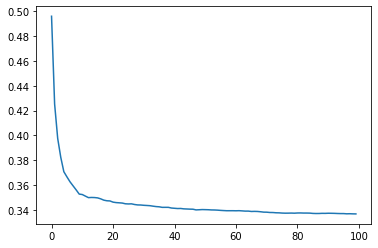

In [18]:
preds = np.stack([t.predict(valid_xs.values) for t in model.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(100)]);

In [19]:
r2_score(valid_y, model.predict(valid_xs.values))

0.9346812547628005

<AxesSubplot:ylabel='cols'>

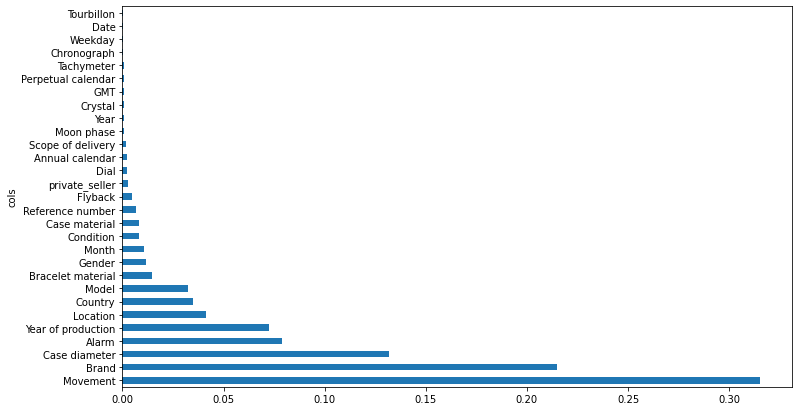

In [20]:
fi = pd.DataFrame({'cols':df.columns.drop(['price', 'is_valid']), 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [21]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

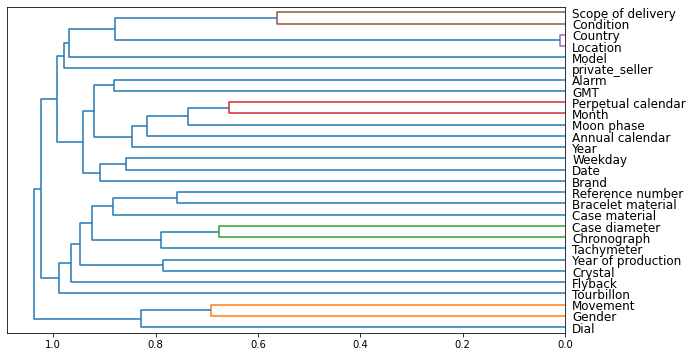

In [22]:
cluster_columns(xs)

In [23]:
keep = fi[fi.imp>0.005].cols
len(keep)

14

In [24]:
xs_i = xs[keep].drop(columns=['Country'])
valid_xs_i = valid_xs[keep].drop(columns=['Country'])

In [25]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
model.fit(xs_i.values, y)

RandomForestRegressor(n_jobs=-1)

In [26]:
r2_score(valid_y, model.predict(valid_xs_i.values))

0.9332237078909071

<AxesSubplot:ylabel='cols'>

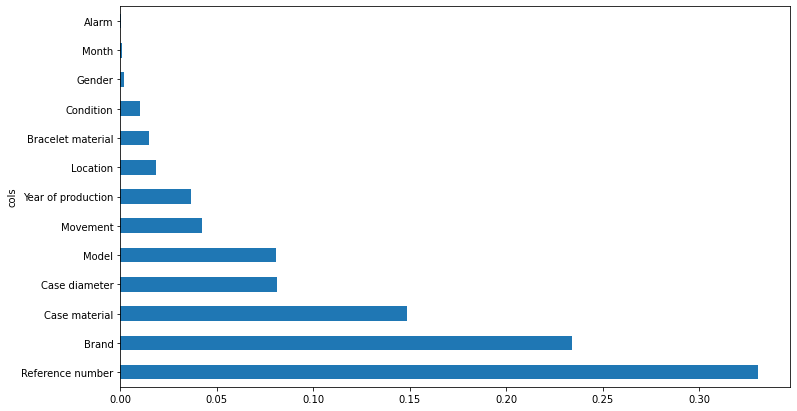

In [27]:
fi = pd.DataFrame({'cols':xs_i.columns, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

[Text(558.0, 713.475, 'Reference number <= 9358.5\nsquared_error = 1.804\nsamples = 23045\nvalue = 8.567'),
 Text(279.0, 509.625, 'Case material <= 4.5\nsquared_error = 1.269\nsamples = 14186\nvalue = 9.091'),
 Text(139.5, 305.775, 'Case diameter <= 35.5\nsquared_error = 0.986\nsamples = 2784\nvalue = 10.047'),
 Text(69.75, 101.92499999999995, '\n  (...)  \n'),
 Text(209.25, 101.92499999999995, '\n  (...)  \n'),
 Text(418.5, 305.775, 'Brand <= 107.5\nsquared_error = 1.058\nsamples = 11402\nvalue = 8.856'),
 Text(348.75, 101.92499999999995, '\n  (...)  \n'),
 Text(488.25, 101.92499999999995, '\n  (...)  \n'),
 Text(837.0, 509.625, 'Case material <= 4.5\nsquared_error = 1.52\nsamples = 8859\nvalue = 7.73'),
 Text(697.5, 305.775, 'Case diameter <= 35.5\nsquared_error = 1.085\nsamples = 683\nvalue = 9.32'),
 Text(627.75, 101.92499999999995, '\n  (...)  \n'),
 Text(767.25, 101.92499999999995, '\n  (...)  \n'),
 Text(976.5, 305.775, 'Movement <= 2.5\nsquared_error = 1.326\nsamples = 8176\nva

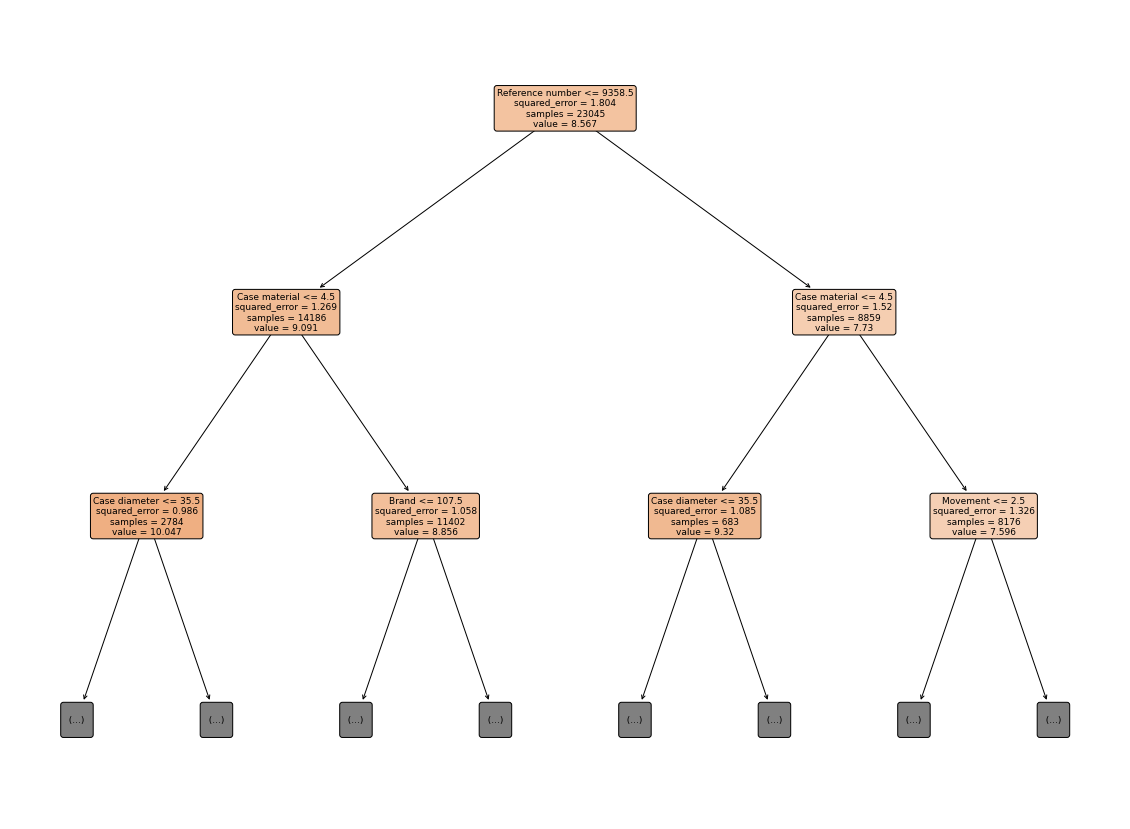

In [28]:
fig = plt.figure(figsize=(20, 15))
tree.plot_tree(model.estimators_[0], feature_names=xs_i.columns, filled=True, impurity=True, 
          rounded=True, max_depth=2)

In [29]:
row = valid_xs_i.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(model, row.values)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

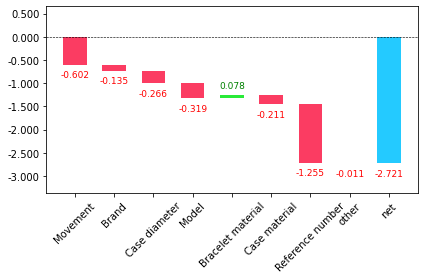

In [30]:
waterfall(valid_xs_i.columns, contributions[0], threshold=0.05, 
          rotation_value=45,formatting='{:,.3f}')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

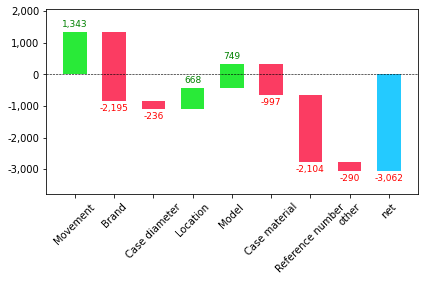

In [61]:
def absolute_contributions(bias, contributions):
    a = []
    b = bias  ## start with the bias as a baseline
    for n in contributions:
        b2 = b + n  ## add contribution to bias
        c = np.exp(b2) - np.exp(b) ## change in absolute terms
        a.append(c)
        b = b2 ## update baseline to new value
    return a
        

waterfall(valid_xs_i.columns, absolute_contributions(bias[1], contributions[1]), threshold=0.1, 
          rotation_value=45,formatting='{:,.0f}')

In [57]:
valid_xs

,Bracelet material,Brand,Case material,Condition,Dial,Gender,Location,Model,Movement,Reference number,...,Tachymeter,Moon phase,Annual calendar,Perpetual calendar,Tourbillon,Flyback,Alarm,Country,Case diameter,Year of production
1,9,134,9,1,10,1,1518,1197,3,18368,...,1,1,1,1,1,1,1,37,39.0,2021.0
12,9,89,9,1,15,1,2460,1002,1,14160,...,1,1,1,1,1,1,1,80,40.0,2021.0
19,7,126,7,3,2,1,3117,1310,1,17677,...,1,1,1,1,1,1,1,81,45.0,2020.0
21,1,123,1,1,2,1,2307,539,1,1400,...,1,1,1,1,1,1,1,78,40.0,2021.0
25,12,126,9,1,9,1,2368,41,1,17978,...,1,1,1,1,1,1,1,80,40.0,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45608,11,105,3,1,5,2,342,545,3,6730,...,1,1,1,1,1,1,1,22,36.0,2021.0
45617,4,123,4,3,7,1,1893,535,1,3443,...,1,1,1,1,1,1,1,70,36.0,1986.0
45620,9,136,9,3,1,1,1660,1295,1,8982,...,1,1,1,1,1,1,1,57,40.0,2007.0
45624,9,79,9,1,15,1,2460,1358,2,16714,...,1,1,1,1,1,1,1,80,28.0,2021.0


In [32]:
to_nn = TabularPandas(df.drop(columns=['is_valid']), [Categorify, Normalize], cat, cont, y_names='price', splits=splitter(df))
len(to.train),len(to.valid)

(36528, 9111)

In [33]:
dls = to_nn.dataloaders(512)

In [34]:
y = to_nn.train.y
y.min(),y.max()

(3.9512436, 13.733472)

In [35]:
learn = tabular_learner(dls, y_range=(3.8,13.9), n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0003981071640737355)

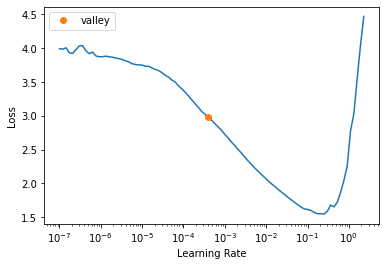

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(20, 0.001)

epoch,train_loss,valid_loss,time
0,1.131238,1.135123,00:00
1,0.390681,0.250539,00:00
2,0.176488,0.175783,00:00
3,0.119081,0.140042,00:00
4,0.084076,0.140373,00:00
5,0.065204,0.144670,00:00
6,0.052162,0.111853,00:00
7,0.044368,0.112119,00:00
8,0.037763,0.106933,00:00
9,0.034684,0.104264,00:00


In [38]:
preds,targs = learn.get_preds()
r2_score(targs, preds)

0.946078418144414

In [39]:
rf_preds = model.predict(valid_xs_i.values)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2
r2_score(valid_y, ens_preds)

0.9503254329444148

In [40]:
from sklearn.decomposition import PCA

In [41]:
#function to embed features ,obtained from fastai forums
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64, device='cuda:0')), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs

In [42]:
emb_xs = embed_features(learn, to_nn.train.xs)
emb_xs.head()

,Case diameter,Year of production,Bracelet material_0,Bracelet material_1,Bracelet material_2,Bracelet material_3,Bracelet material_4,Bracelet material_5,Bracelet material_6,Brand_0,...,Country_9,Country_10,Country_11,Country_12,Country_13,Country_14,Country_15,Country_16,Country_17,Country_18
0,0.451302,0.686792,0.010140,0.007377,0.011295,-0.001531,-0.024196,-0.008409,0.019610,0.004973,...,-0.018906,0.012647,-0.000410,0.004649,0.001180,0.005342,0.015899,-0.007916,0.000820,-0.007664
2,0.451302,0.686792,0.010213,0.002705,0.014313,-0.007479,-0.007449,-0.035527,-0.004609,0.006719,...,0.004067,0.014728,-0.020437,-0.001423,0.004475,-0.002583,0.019950,-0.033408,0.015201,0.007343
3,0.619675,0.686792,0.010140,0.007377,0.011295,-0.001531,-0.024196,-0.008409,0.019610,0.006719,...,0.004067,0.014728,-0.020437,-0.001423,0.004475,-0.002583,0.019950,-0.033408,0.015201,0.007343
4,0.619675,0.686792,0.010213,0.002705,0.014313,-0.007479,-0.007449,-0.035527,-0.004609,-0.001991,...,0.004067,0.014728,-0.020437,-0.001423,0.004475,-0.002583,0.019950,-0.033408,0.015201,0.007343
5,0.282930,0.686792,0.010140,0.007377,0.011295,-0.001531,-0.024196,-0.008409,0.019610,0.000846,...,0.002666,-0.003939,-0.000638,0.011936,-0.007890,0.006160,-0.032009,0.015370,-0.003467,-0.006569


In [43]:
def get_feature_embs(feature, components, threshold):
    out = emb_xs.filter(regex=feature)
    values = df.loc[out.index.values, feature].values ## save the pre-encoded value names
    
    out = PCA(n_components=components).fit_transform(out)
    out = pd.DataFrame(out)
    out['value'] = values
    out = out.groupby('value').filter(lambda x : len(x)>(len(out)*threshold)) ## filter out values based on threshold
    out = out.groupby('value').first()
    out = out.dropna()
    
    return out

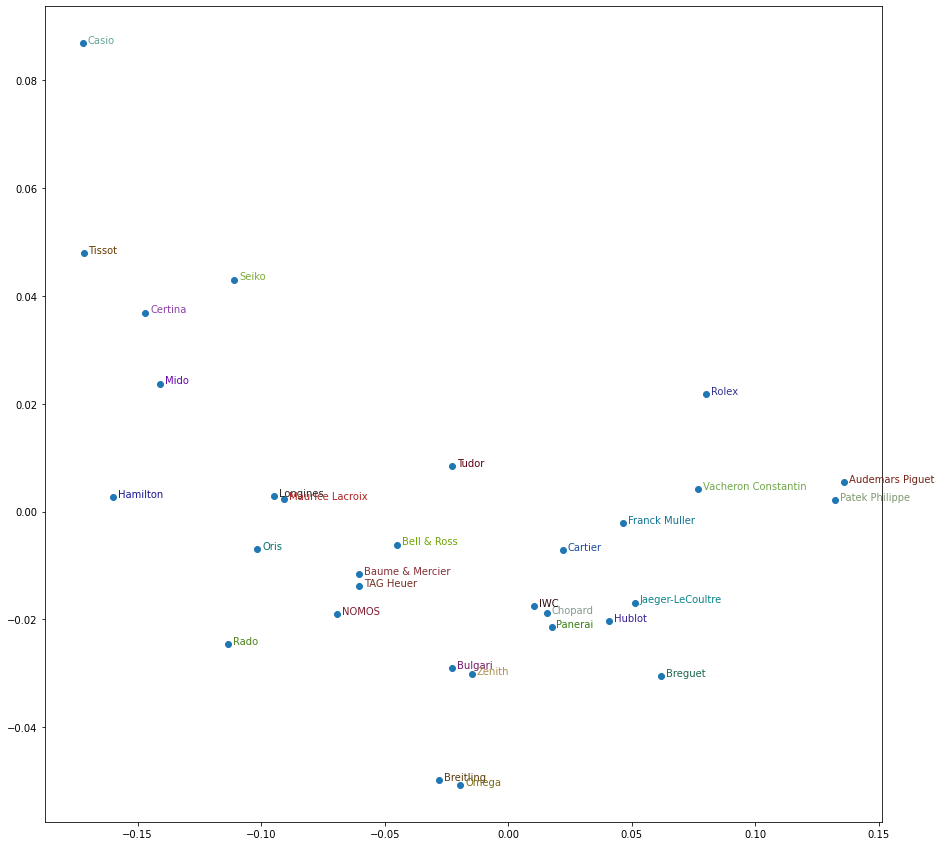

In [44]:
emb_case = get_feature_embs('Brand', 2, 0.005)

plt.figure(figsize=(15,15))
plt.scatter(emb_case[0], emb_case[1])
for i, x, y in zip(emb_case.index, emb_case[0], emb_case[1]):
    plt.text(x+0.002,y,i, color=np.random.rand(3)*0.7, fontsize=10)
plt.show()

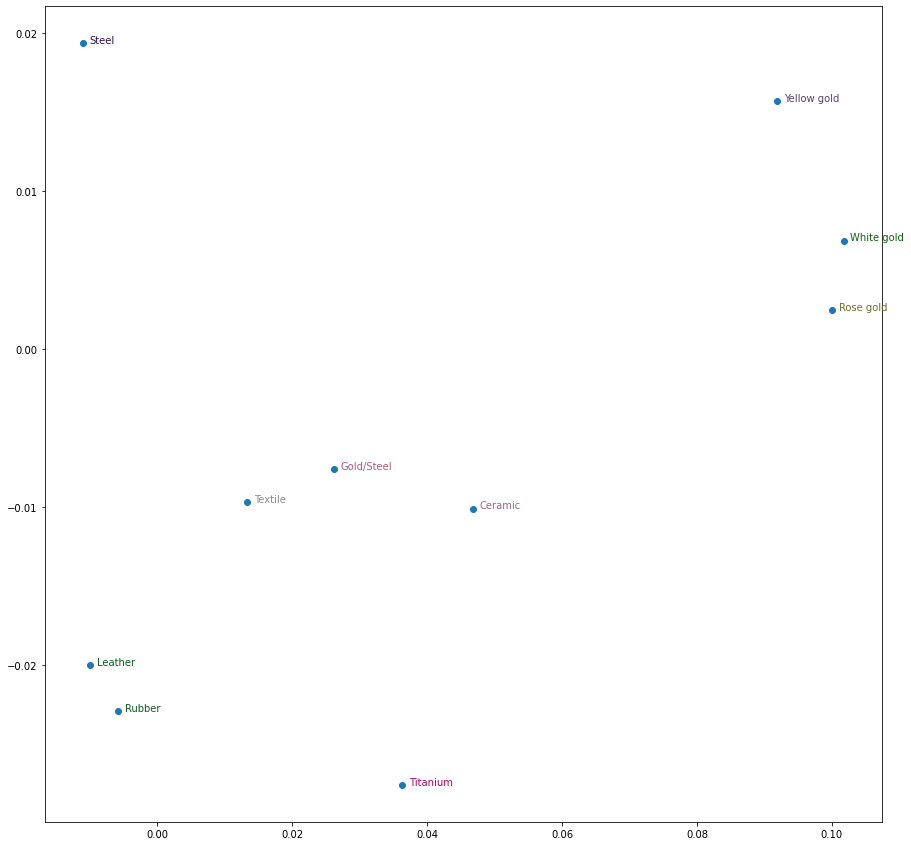

In [45]:
emb_case = get_feature_embs('Bracelet material', 2, 0.005)

plt.figure(figsize=(15,15))
plt.scatter(emb_case[0], emb_case[1])
for i, x, y in zip(emb_case.index, emb_case[0], emb_case[1]):
    plt.text(x+0.001,y,i, color=np.random.rand(3)*0.7, fontsize=10)
plt.show()